# Proyek Klasifikasi Gambar: Digikala Products Color Classification
- **Nama:** Muhammad Fikri Fadillah
- **Email:** fikriu13@gmail.com
- **ID Dicoding:** fikriu13

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import splitfolders

print("Semua library berhasil diimport!")

Semua library berhasil diimport!


## Data Preparation

In [2]:
# Path ke dataset awal
input_folder = "dataset"  
output_folder = "dataset_split"

# Membagi dataset (80% train, 10% val, 10% test)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None)

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


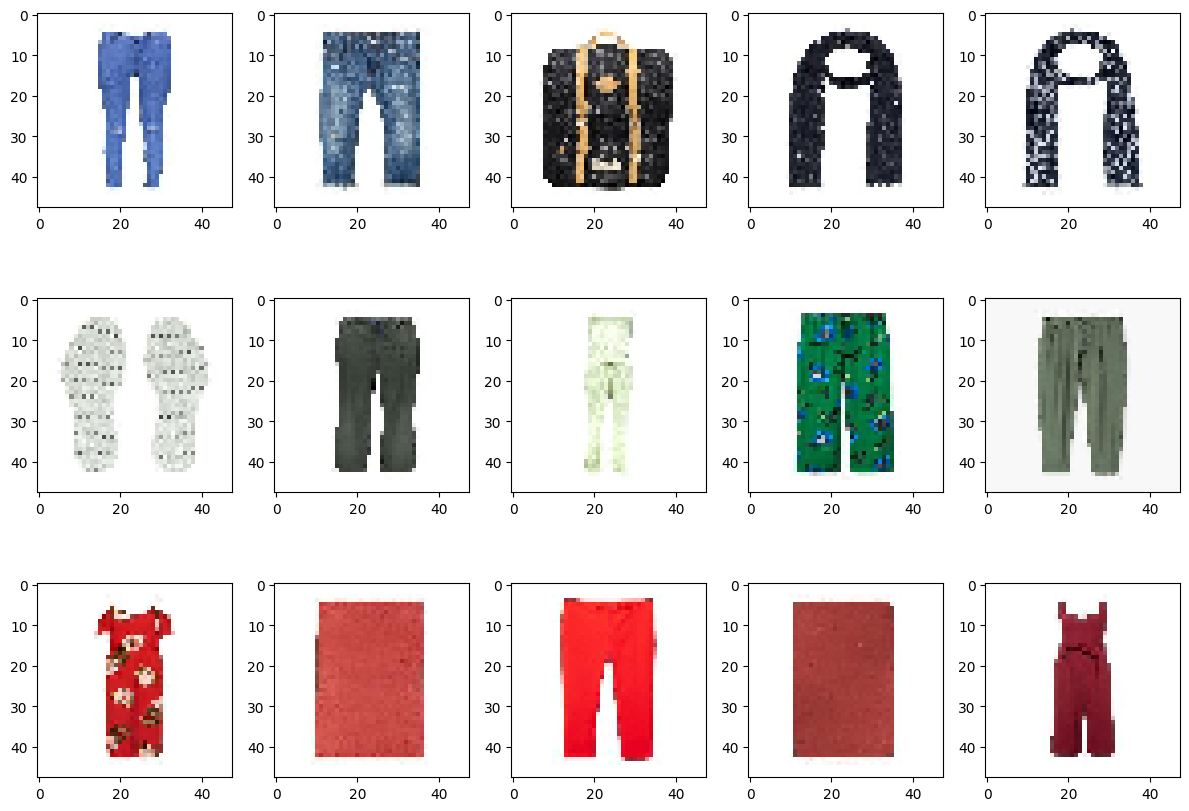

In [3]:
# display some images for every different labels

pic_size = 48

# input path for the images
base_path = "dataset_split/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)

plt.tight_layout()
plt.show()

In [4]:
batch_size = 128
base_path = "dataset_split/"

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation set, only rescaling
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(56, 56),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + "val",
    target_size=(56, 56),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1634 images belonging to 3 classes.
Found 203 images belonging to 3 classes.


## Modelling

In [5]:
# Jumlah kelas
nb_classes = 3

# Model CNN
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3,3), padding='same', input_shape=(56, 56, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))  

# 2nd Convolutional Layer
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  

# 4th Convolutional Layer
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))  

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  

# Output Layer
model.add(Dense(nb_classes, activation='softmax'))

# Optimizer dengan Learning Rate kecil
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks untuk meningkatkan akurasi
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Tampilkan model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        2

In [6]:
# Jumlah epoch untuk training
epochs = 50

# Checkpoint untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

# Daftar callbacks
callbacks_list = [checkpoint]

# Menghitung jumlah langkah per epoch
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = np.ceil(validation_generator.n / validation_generator.batch_size)

# Training model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

Epoch 1/50
12/12 [==============================] - 18s 1s/step - loss: 1.2119 - accuracy: 0.3958 - val_loss: 1.0943 - val_accuracy: 0.5320

Epoch 00001: val_accuracy improved from -inf to 0.53202, saving model to best_model.h5
Epoch 2/50
12/12 [==============================] - 11s 880ms/step - loss: 0.7569 - accuracy: 0.6344 - val_loss: 1.0931 - val_accuracy: 0.3300

Epoch 00002: val_accuracy did not improve from 0.53202
Epoch 3/50
12/12 [==============================] - 10s 860ms/step - loss: 0.5490 - accuracy: 0.7669 - val_loss: 1.0916 - val_accuracy: 0.3645

Epoch 00003: val_accuracy did not improve from 0.53202
Epoch 4/50
12/12 [==============================] - 11s 875ms/step - loss: 0.4759 - accuracy: 0.8231 - val_loss: 1.0915 - val_accuracy: 0.3202

Epoch 00004: val_accuracy did not improve from 0.53202
Epoch 5/50
12/12 [==============================] - 10s 848ms/step - loss: 0.3780 - accuracy: 0.8649 - val_loss: 1.0922 - val_accuracy: 0.3202

Epoch 00005: val_accuracy did n

## Evaluasi dan Visualisasi

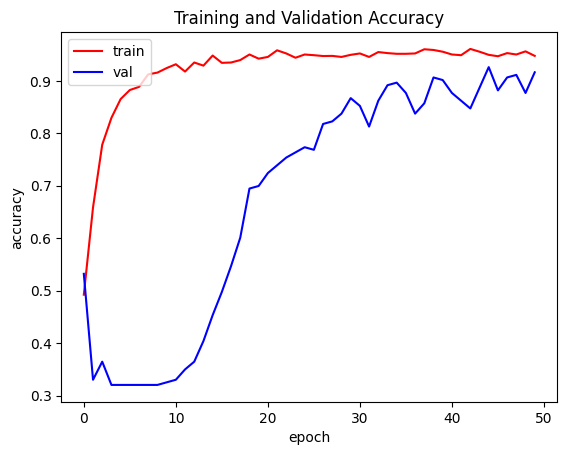

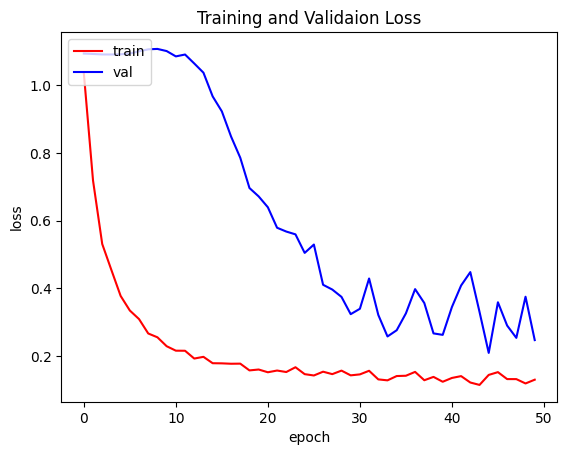

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
 
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [8]:
# Path dataset uji
test_dir = base_path + "test"

# Generator untuk test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(56, 56),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False
)

# Prediksi pada test set menggunakan model yang sudah dilatih
y_pred_prob = model.predict(test_generator)

# Konversi probabilitas menjadi label kelas
y_pred = np.argmax(y_pred_prob, axis=1)

# Ambil label asli dari test set
y_true = test_generator.classes

# Ambil nama kelas sesuai indeks
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))


Found 207 images belonging to 3 classes.
Confusion Matrix:
 [[63  2  1]
 [ 3 68  0]
 [ 2  3 65]]
Classification Report:
               precision    recall  f1-score   support

        blue       0.93      0.95      0.94        66
       green       0.93      0.96      0.94        71
         red       0.98      0.93      0.96        70

    accuracy                           0.95       207
   macro avg       0.95      0.95      0.95       207
weighted avg       0.95      0.95      0.95       207



## Konversi Model

In [9]:
# 1. SavedModel format
model.save("model_saved")

# 2. TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label ke dalam file txt
label_dict = {'happy': 0, 'neutral': 1, 'sad': 2}

with open("labels.txt", "w") as f:
    for label, index in sorted(label_dict.items(), key=lambda item: item[1]):
        f.write(f"{label}\n")

# 3. TFJS format
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

INFO:tensorflow:Assets written to: model_saved\assets
INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpkexnbp6w\assets


2025-03-09 20:46:26.415784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


## Inference

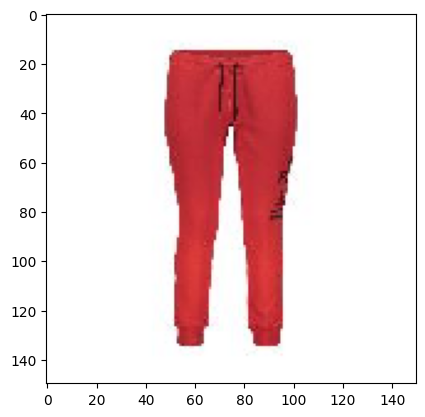

Prediksi: red


In [10]:
# Load model
model = load_model("best_model.h5")

# Label kelas sesuai urutan training
labels = ["blue", "green", "red"]  

# Input path gambar dari user
uploaded = input("Masukkan path gambar: ").strip()

if os.path.exists(uploaded):  
    img = image.load_img(uploaded, target_size=(150, 150), color_mode="rgb") 
    imgplot = plt.imshow(img)
    plt.show()

    # Preprocessing gambar
    x = image.img_to_array(img)  
    x = np.expand_dims(x, axis=0)  
    x /= 255.0  

    # Prediksi kelas
    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    # Cetak hasil prediksi
    print(f"Prediksi: {labels[predicted_class]}")
else:
    print("File tidak ditemukan!")
